In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
AccountingAudit vs. Review vs. Compilation,0.008051,0.008051,0.008051,1
OAuth 2.0 RFC6749,17.153115,1.559374,3.280825,11
Accounting,20.710503,1.294406,4.836049,16
pfSense,28.033742,2.336145,4.847525,12
Pandas,139.157893,46.385964,53.591434,3
Python + Oauth2.0,296.920075,12.909568,24.411899,23
Azure Files Documentation,344.588187,10.768381,24.491758,32
Terraform,925.498767,92.549877,214.625127,10
Azure DevOps Pipelines,1050.443286,105.044329,199.649114,10
Power BI,1228.140066,37.216366,58.656137,33


# Histogram

sum of ages: ~48962.02


<Axes: >

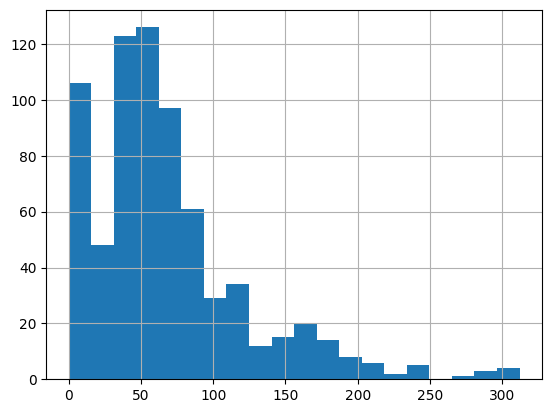

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~48962.02


<Axes: >

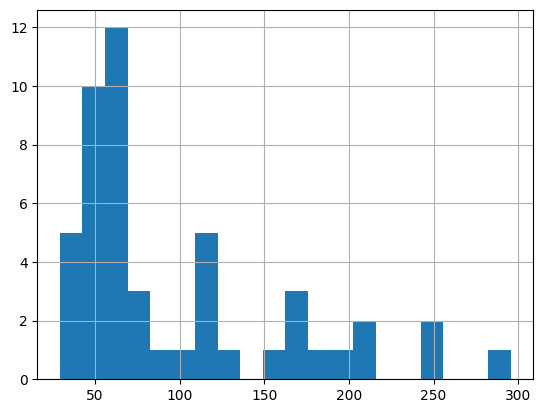

In [25]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='PnP PowerShell']['age'].hist(bins=20)

# Completely Random Shuffle

In [26]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [27]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [28]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [31]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [32]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [33]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 714
Total card age: 48962.02


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
0,PnP PowerShell,Export-PnPProvisioningTemplate (PnP.PowerShell...,fa28f8230bbc691d7374863ca568f6cc,-295.618763,97.653197,295.618763,-4785.006672,0.176864,49,0,0
1,PnP PowerShell,Add-PnPFile (PnP.PowerShell)\nUploads a file t...,63e93b503d2fce02918c720efcf961ab,-213.976770,97.653197,295.618763,-4785.006672,0.176864,49,3,0
2,PnP PowerShell,Export-Clixml (Microsoft.PowerShell.Utility)\n...,9d1b01266cc25388fb7733222f501b3f,-180.995787,97.653197,295.618763,-4785.006672,0.176864,49,6,0
3,PnP PowerShell,PowerShell Profiles\nScripts that run automati...,52e04b62c431b8b8a3369ebe7b88db8c,-162.771448,97.653197,295.618763,-4785.006672,0.176864,49,9,0
4,PnP PowerShell,Azure Key Vault Integration\nSecurely stores a...,accda5d72061d91a1b761cd2cb6550e4,-119.713696,97.653197,295.618763,-4785.006672,0.176864,49,12,0
5,PnP PowerShell,Set-PnPWeb (PnP.PowerShell)\nConfigures proper...,0b5e33252788b38f6e7cbbc352a67c7a,-111.988313,97.653197,295.618763,-4785.006672,0.176864,49,15,0
6,PnP PowerShell,SharePoint App Permissions\nDefines the access...,070e38162f80edb6a4f249647d0f042a,-92.774563,97.653197,295.618763,-4785.006672,0.176864,49,18,0
241,PnP PowerShell,New-PnPField (PnP.PowerShell)\nCreates a new f...,04508705a26781576ead2337537dc1ea,-69.765593,97.653197,295.618763,-4785.006672,0.176864,49,21,0
464,PnP PowerShell,Remove-PnPUserFromGroup (PnP.PowerShell)\nRemo...,95c2cc05d62ec6ac737120ec99d340cd,-65.348684,97.653197,295.618763,-4785.006672,0.176864,49,24,0
9,PnP PowerShell,PSCredential Object (Microsoft.PowerShell.Secu...,9361d07e9c0d80ee4f3b4252b8f94f5f,-62.049165,97.653197,295.618763,-4785.006672,0.176864,49,27,0


## Age Mean

In [34]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [36]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [37]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [38]:
existing_cards.head(10)['age'].sum()

np.float64(-1375.0027822269003)

In [39]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
127,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-311.908907,100.927362,311.908907,-2422.256692,0.183267,24,0,0
153,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-311.353400,92.112527,311.353400,-1658.025484,0.291327,18,0,0
17,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,-306.987331,89.148212,306.987331,-4724.855247,0.518943,53,0,0
186,Azure Developer Associate,Your company is developing a new web applicati...,466f3aae7fb7958ec8752dd6ace75557,-303.406968,185.654591,303.406968,-1485.236732,0.791193,8,0,0
0,PnP PowerShell,Export-PnPProvisioningTemplate (PnP.PowerShell...,fa28f8230bbc691d7374863ca568f6cc,-295.618763,97.653197,295.618763,-4785.006672,0.176864,49,0,0
249,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,-285.927330,89.148212,306.987331,-4724.855247,0.518943,53,1,1
60,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,-280.918308,84.885305,280.918308,-4159.379929,0.666951,49,0,0
106,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,-276.646572,92.330262,276.646572,-2585.247336,0.869076,28,0,0
233,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,-248.624129,97.653197,295.618763,-4785.006672,0.176864,49,1,1
336,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,-247.544262,92.330262,276.646572,-2585.247336,0.869076,28,1,1


In [40]:
existing_cards['age'].mean()

np.float64(-68.57426417893927)